In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid", palette="colorblind")

In [2]:
pbp_py_pass = pd.read_pickle("../datasets/filtered_nfl_pass_ch5_plays.pkl")

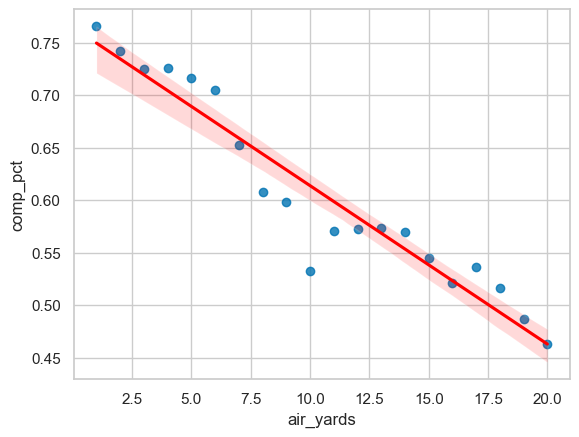

In [3]:
# Analyze completion percentage by air yards
pass_pct_py = (
    pbp_py_pass
    .query('0 < air_yards <= 20')
    .groupby('air_yards')
    .agg({"complete_pass": ["mean"]})
)
pass_pct_py.columns = ['_'.join(col) for col in pass_pct_py.columns]
pass_pct_py = pass_pct_py.rename(columns={'complete_pass_mean': 'comp_pct'}).reset_index()

# Create regression plot
sns.regplot(data=pass_pct_py, x='air_yards', y='comp_pct',
            line_kws={'color': 'red'})
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:          complete_pass   No. Observations:               131607
Model:                            GLM   Df Residuals:                   131605
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81066.
Date:                Tue, 01 Apr 2025   Deviance:                   1.6213e+05
Time:                        11:16:23   Pearson chi2:                 1.32e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07025
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0727      0.008    133.348      0.0

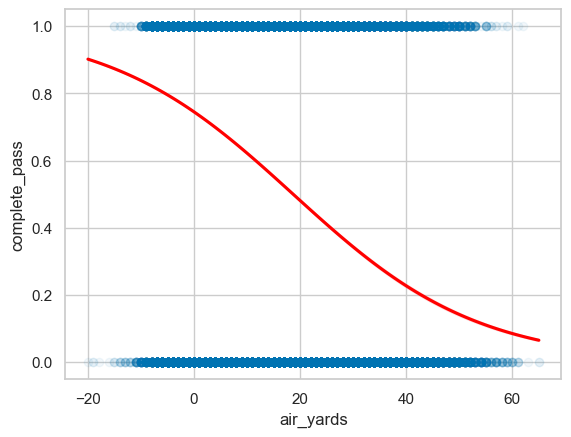

In [4]:
# Simple logistic regression with air yards
complete_ay_py = smf.glm(
    formula='complete_pass ~ air_yards',
    data=pbp_py_pass,
    family=sm.families.Binomial()
).fit()
print(complete_ay_py.summary())

# Visualize logistic relationship
sns.regplot(data=pbp_py_pass, x='air_yards', y='complete_pass',
            logistic=True, line_kws={'color': 'red'}, scatter_kws={'alpha':0.05})
plt.show()

In [6]:
# Prepare data for complex model
pbp_py_pass['down'] = pbp_py_pass['down'].astype(str)
pbp_py_pass['qb_hit'] = pbp_py_pass['qb_hit'].astype(str)
pbp_py_pass_no_miss = pbp_py_pass[
    ["passer", "passer_id", "season", "down", "qb_hit", "complete_pass",
     "ydstogo", "yardline_100", "air_yards", "pass_location"]
].dropna()

# Build comprehensive GLM
complete_more_py = smf.glm(
    formula='complete_pass ~ down * ydstogo + yardline_100 + air_yards + pass_location + qb_hit',
    data=pbp_py_pass_no_miss,
    family=sm.families.Binomial()
).fit()

In [10]:
# Calculate expected completions and CPOE
pbp_py_pass_no_miss["exp_completion"] = complete_more_py.predict()
pbp_py_pass_no_miss["cpoe"] = pbp_py_pass_no_miss["complete_pass"] - pbp_py_pass_no_miss["exp_completion"]

# Aggregate player statistics
cpoe_py_more = (
    pbp_py_pass_no_miss
    .groupby(["season", "passer_id", "passer"])
    .agg(
        n=('cpoe', 'count'),
        cpoe=('cpoe', 'mean'),
        compl=('complete_pass', 'mean'),
        exp_completion=('exp_completion', 'mean')
    )
    .query("n > 100")
    .reset_index()
)

# Display top performers
print(cpoe_py_more.sort_values("cpoe", ascending=False).head(20))

     season   passer_id         passer    n      cpoe     compl  \
85     2018  00-0020531        D.Brees  566  0.088887  0.738516   
126    2019  00-0020531        D.Brees  406  0.087842  0.756158   
192    2020  00-0033357         T.Hill  121  0.082915  0.727273   
12     2016  00-0026143         M.Ryan  631  0.077526  0.702060   
193    2020  00-0033537       D.Watson  542  0.072850  0.704797   
139    2019  00-0029701    R.Tannehill  343  0.066689  0.690962   
16     2016  00-0027854     S.Bradford  551  0.061438  0.716878   
92     2018  00-0023682  R.Fitzpatrick  246  0.061306  0.666667   
172    2020  00-0023459      A.Rodgers  607  0.061116  0.705107   
93     2018  00-0026143         M.Ryan  607  0.059642  0.695222   
111    2018  00-0032950        C.Wentz  399  0.058200  0.699248   
41     2017  00-0020531        D.Brees  606  0.057378  0.716172   
247    2021  00-0036442       J.Burrow  659  0.055980  0.702580   
11     2016  00-0025708        M.Moore  122  0.055582  0.68852

In [11]:
# Prepare data for year-to-year comparison
cols_keep = ["season", "passer_id", "passer", "cpoe", "compl", "exp_completion"]
cpoe_now_py = cpoe_py_more[cols_keep].copy()
cpoe_last_py = cpoe_now_py.rename(columns={
    'cpoe': 'cpoe_last',
    'compl': 'compl_last',
    'exp_completion': 'exp_completion_last'
})
cpoe_last_py["season"] += 1

# Merge and calculate correlations
cpoe_lag_py = cpoe_now_py.merge(cpoe_last_py, on=["passer_id", "passer", "season"])
print("Completion% Stability:", cpoe_lag_py[['compl_last', 'compl']].corr())
print("CPOE Stability:", cpoe_lag_py[['cpoe_last', 'cpoe']].corr())

Completion% Stability:             compl_last    compl
compl_last     1.00000  0.44578
compl          0.44578  1.00000
CPOE Stability:            cpoe_last      cpoe
cpoe_last   1.000000  0.465738
cpoe        0.465738  1.000000
